<a href="https://colab.research.google.com/github/leosammallahti/AnalysisCoLab/blob/main/RCTAnalysis2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

RCT Data Analysis Pipeline
Pandas version: 2.2.2
NumPy version: 2.0.2
Data path: /content/drive/MyDrive/AEA_RCT_Parsed/studies_with_ai_keywords_enriched.csv
Together API available: False

Loading data...
Loaded 2124 rows
Columns (31): ['title', 'country', 'subregion', 'abstract', 'description_of_intervention', 'primary_outcomes', 'secondary_outcomes', 'population', 'search_vector', 'keywords', 'keywords_additional', 'jel_codes', 'keywords_sector', 'keywords_mechanisms', 'keywords_implementation', 'keywords_context', 'researchers', 'researcher_affiliation', 'year', 'findings', 'rct_id', 'tldr', 'intervention_type', 'outcome_extracted', 'population_extracted', 'keywords_methodology', 'keywords_partners', 'findings_snippet', 'final_findings_snippet', 'publication_year', 'interventions']

                 column coverage%
               abstract      99.8
                   tldr     100.0
      intervention_type      99.7
      outcome_extracted      99.7
   population_extracted      99.3


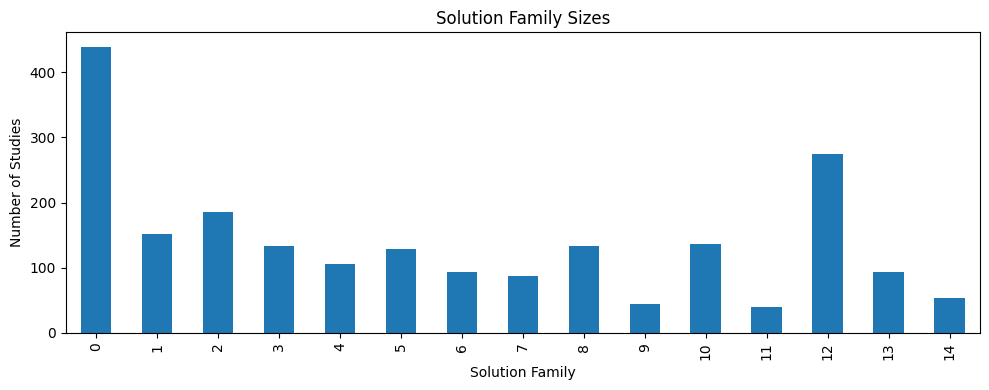

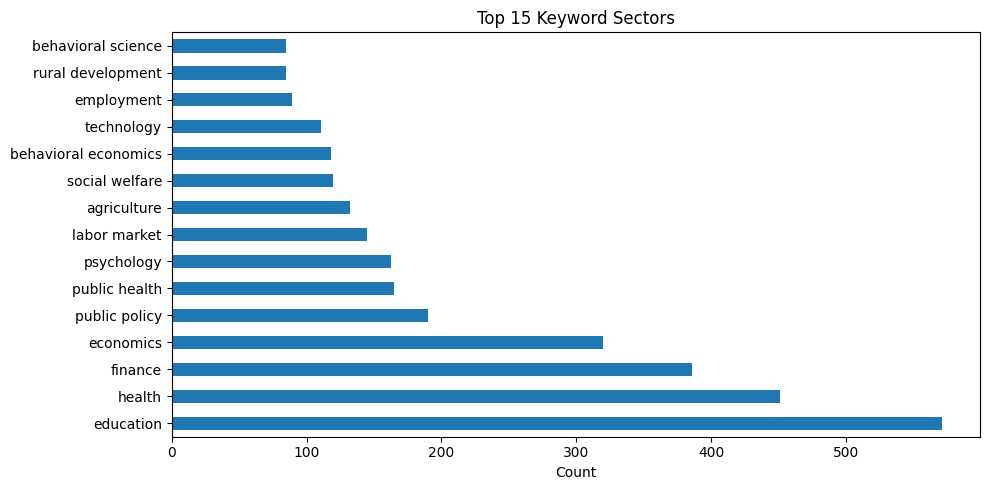


Top DNA Components per Solution Family:
------------------------------------------------------------
Family 0:
  00_experiment_participa: 69.9%
  06_information_tax_trea: 57.2%
  08_insurance_farmers_pr: 48.1%
Family 1:
  00_experiment_participa: 87.4%
  06_information_tax_trea: 68.9%
  02_training_program_ski: 35.1%
Family 2:
  07_cash_transfers_trans: 74.7%
  02_training_program_ski: 50.5%
  08_insurance_farmers_pr: 47.8%
Family 3:
  06_information_tax_trea: 91.7%
  00_experiment_participa: 89.5%
  04_inflation_expectatio: 60.2%
Family 4:
  05_financial_savings_lo: 99.0%
  06_information_tax_trea: 41.9%
  00_experiment_participa: 31.4%
Family 5:
  03_job_work_employment: 97.7%
  02_training_program_ski: 41.4%
  06_information_tax_trea: 39.8%
Family 6:
  02_training_program_ski: 95.7%
  08_insurance_farmers_pr: 37.2%
  03_job_work_employment: 34.0%
Family 7:
  08_insurance_farmers_pr: 100.0%
  02_training_program_ski: 44.8%
  06_information_tax_trea: 41.4%
Family 8:
  06_information_

In [10]:
"""
Complete RCT Data Analysis Pipeline
Single robust, idempotent Google Colab cell for end-to-end analysis
"""

# ========== 1. SETUP ==========
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import NMF
import matplotlib.pyplot as plt
import seaborn as sns
import os
import json
import warnings
import time

# Check for Together API
try:
    # Use Colab's user data to securely access the API key
    from google.colab import userdata
    together_api_key = userdata.get("TOGETHER_API_KEY")
    if together_api_key:
        os.environ["TOGETHER_API_KEY"] = together_api_key # Set environment variable for the 'together' library
        from together import Together
        together_available = True
    else:
        together_available = False
except ImportError:
    together_available = False
except Exception as e:
    print(f"Error accessing Together API key from userdata: {e}")
    together_available = False


# Configuration
SEED = 42
np.random.seed(SEED)
warnings.filterwarnings('ignore', category=FutureWarning)
warnings.filterwarnings('ignore', category=UserWarning)

# Editable data path
DATA_PATH = '/content/drive/MyDrive/AEA_RCT_Parsed/studies_with_ai_keywords_enriched.csv'

print("="*50)
print("RCT Data Analysis Pipeline")
print("="*50)
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")
print(f"Data path: {DATA_PATH}")
print(f"Together API available: {together_available}")
print()

# ========== 2. LOAD AND NORMALIZE ==========
print("Loading data...")
df = pd.read_csv(DATA_PATH, low_memory=False)
df.columns = df.columns.str.lower()
print(f"Loaded {len(df)} rows")
print(f"Columns ({len(df.columns)}): {list(df.columns)}")
print()

# Coverage analysis
coverage_cols_initial = ['abstract', 'tldr', 'intervention_type', 'outcome_extracted',
                 'population_extracted', 'country', 'subregion', 'year', 'population',
                 'keywords_sector', 'keywords_mechanisms', 'keywords_implementation',
                 'keywords_context', 'jel_codes', 'interventions', 'intervention_structured']

coverage_cols = [col for col in coverage_cols_initial if col in df.columns]


coverage_data = []
for col in coverage_cols:
    non_null = df[col].notna().sum()
    pct = (non_null / len(df)) * 100
    coverage_data.append({'column': col, 'coverage%': f"{pct:.1f}"})

coverage_df = pd.DataFrame(coverage_data)
print(coverage_df.to_string(index=False))
print()

# Filter by abstract length
df['abstract_length'] = df['abstract'].fillna('').apply(len)
original_count = len(df)
df = df[df['abstract_length'] >= 100].copy()
print(f"Abstract filter: kept {len(df)}/{original_count} rows (removed {original_count - len(df)})")
print()

# ========== 3. DATA-DRIVEN COMPONENT DISCOVERY ==========
print("="*50)
print("3. Discovering intervention components via NMF")
print("="*50)

# Build intervention text from available columns
intervention_parts = []
for col in ['intervention_structured', 'interventions', 'intervention_type', 'tldr']:
    if col in df.columns:
        intervention_parts.append(df[col].fillna(''))
if len(intervention_parts) > 0:
    df['intervention_text'] = intervention_parts[0]
    for part in intervention_parts[1:]:
        df['intervention_text'] = df['intervention_text'] + ' ' + part
else:
    # Fallback to abstract if no intervention columns
    df['intervention_text'] = df['abstract'].fillna('')

# TF-IDF vectorization
print("Vectorizing intervention text...")
tfidf = TfidfVectorizer(max_features=5000, stop_words='english',
                        min_df=5, max_df=0.9, ngram_range=(1,2))
X_intervention = tfidf.fit_transform(df['intervention_text'])
print(f"TF-IDF matrix shape: {X_intervention.shape}")

# Find optimal number of topics using elbow method
print("\nFinding optimal number of topics...")
errors = []
k_range = range(8, 21)
for k in k_range:
    nmf = NMF(n_components=k, random_state=SEED, init='nndsvd', max_iter=400)
    W = nmf.fit_transform(X_intervention)
    errors.append(nmf.reconstruction_err_)

# Find elbow - smallest k where improvement < 5%
chosen_k = k_range[-1]  # default to max if no elbow
for i in range(1, len(errors)):
    if i > 0:
        relative_improvement = (errors[i-1] - errors[i]) / errors[i-1]
        if relative_improvement < 0.05:
            chosen_k = list(k_range)[i]
            break

print("K\tReconstruction Error")
for k, err in zip(k_range, errors):
    marker = " <-- chosen" if k == chosen_k else ""
    print(f"{k}\t{err:.4f}{marker}")

# Fit final NMF with chosen k
print(f"\nUsing {chosen_k} topics")
nmf_final = NMF(n_components=chosen_k, random_state=SEED, init='nndsvd', max_iter=400)
W_final = nmf_final.fit_transform(X_intervention)
H_final = nmf_final.components_

# Extract and label topics
feature_names = np.array(tfidf.get_feature_names_out())
topic_labels = []
topic_terms_dict = {}

print("\nTopic labels and top terms:")
for topic_idx in range(chosen_k):
    top_indices = H_final[topic_idx].argsort()[-10:][::-1]
    top_terms = feature_names[top_indices]
    label = '_'.join(top_terms[:3])
    label = label.replace(' ', '_').replace('-', '_')[:50]  # safe slug
    topic_labels.append(label)
    topic_terms_dict[topic_idx] = list(top_terms)
    print(f"Topic {topic_idx}: {label[:30]}...")

# Create binary DNA component columns
print("\nCreating binary DNA component indicators...")
for topic_idx in range(chosen_k):
    # Get weights for this topic across all docs
    topic_weights = W_final[:, topic_idx]

    # Calculate 80th percentile threshold
    threshold_80 = np.percentile(topic_weights, 80)

    # For each doc, check if this topic is active
    is_top_3 = np.zeros(len(df), dtype=bool)
    for doc_idx in range(len(df)):
        doc_topics = W_final[doc_idx].argsort()[-3:][::-1]
        if topic_idx in doc_topics:
            is_top_3[doc_idx] = True

    # Topic is active if it's top-3 OR above 80th percentile
    is_active = is_top_3 | (topic_weights >= threshold_80)

    col_name = f"dna_comp_{topic_idx:02d}_{topic_labels[topic_idx][:20]}"
    df[col_name] = is_active.astype(int)

# Summary of DNA components
print("\nDNA Component Summary:")
dna_cols = [col for col in df.columns if col.startswith('dna_comp_')]
for col in dna_cols[:5]:  # Show first 5
    active_pct = (df[col].sum() / len(df)) * 100
    print(f"{col}: {active_pct:.1f}% active")
print(f"... ({len(dna_cols)} total components)")
print()

# ========== 4. PREPARE TEXT FOR CLUSTERING ==========
print("="*50)
print("4. Preparing text for Solution Family clustering")
print("="*50)

# Build intervention essence from available columns
essence_parts = []
for col in ['intervention_type', 'tldr', 'outcome_extracted', 'population_extracted']:
    if col in df.columns and df[col].notna().sum() > 0:
        essence_parts.append(df[col].fillna(''))
        print(f"Using {col} for intervention essence")

if essence_parts:
    df['intervention_essence'] = essence_parts[0]
    for part in essence_parts[1:]:
        df['intervention_essence'] = df['intervention_essence'] + ' ' + part
else:
    df['intervention_essence'] = df['abstract'].fillna('')

# Filter by essence length
df['essence_length'] = df['intervention_essence'].apply(len)
df_cluster = df[df['essence_length'] > 50].copy()
print(f"Kept {len(df_cluster)} rows with essence length > 50")

# TF-IDF for clustering
tfidf_cluster = TfidfVectorizer(max_features=200, stop_words='english',
                                min_df=3, max_df=0.8, ngram_range=(1,2))
X_cluster = tfidf_cluster.fit_transform(df_cluster['intervention_essence'])
print(f"Clustering vector shape: {X_cluster.shape}")
feature_names_cluster = tfidf_cluster.get_feature_names_out()
print(f"First 20 features: {list(feature_names_cluster[:20])}")
print()

# ========== 5. FIND OPTIMAL K AND CLUSTER ==========
print("="*50)
print("5. Finding optimal number of Solution Families")
print("="*50)

k_range_cluster = range(5, 16)
silhouette_scores = []

print("K\tSilhouette Score")
for k in k_range_cluster:
    kmeans = KMeans(n_clusters=k, random_state=SEED, n_init=10)
    labels = kmeans.fit_predict(X_cluster)
    score = silhouette_score(X_cluster, labels, sample_size=min(5000, X_cluster.shape[0]))
    silhouette_scores.append({'k': k, 'silhouette': score})
    print(f"{k}\t{score:.4f}")

# Find best k
best_k = max(silhouette_scores, key=lambda x: x['silhouette'])['k']
print(f"\nBest k: {best_k} (highest silhouette score)")

# Final clustering
kmeans_final = KMeans(n_clusters=best_k, random_state=SEED, n_init=20)
df_cluster['solution_family'] = kmeans_final.fit_predict(X_cluster)

# Cluster sizes
cluster_sizes = df_cluster['solution_family'].value_counts().sort_index()
print("\nCluster sizes:")
for cluster_id, size in cluster_sizes.items():
    pct = (size / len(df_cluster)) * 100
    print(f"Family {cluster_id}: {size} ({pct:.1f}%)")
print()

# ========== 6. OUTLIER DETECTION ==========
print("="*50)
print("6. Outlier detection")
print("="*50)

# Calculate distances to centroids
distances = []
for idx, row in df_cluster.iterrows():
    cluster_id = row['solution_family']
    centroid = kmeans_final.cluster_centers_[cluster_id]
    doc_vector = X_cluster[df_cluster.index.get_loc(idx)]
    dist = np.linalg.norm(doc_vector.toarray() - centroid)
    distances.append(dist)

df_cluster['distance_to_centroid'] = distances
threshold = np.percentile(distances, 90)
df_cluster['outlier_flag'] = (df_cluster['distance_to_centroid'] > threshold).astype(int)

print(f"Overall outliers: {df_cluster['outlier_flag'].sum()} ({df_cluster['outlier_flag'].mean()*100:.1f}%)")
print("\nOutliers per family:")
for cluster_id in sorted(df_cluster['solution_family'].unique()):
    cluster_data = df_cluster[df_cluster['solution_family'] == cluster_id]
    outlier_count = cluster_data['outlier_flag'].sum()
    outlier_pct = (outlier_count / len(cluster_data)) * 100
    print(f"Family {cluster_id}: {outlier_count}/{len(cluster_data)} ({outlier_pct:.1f}%)")
print()

# ========== 7. AGGREGATIONS AND DISTRIBUTIONS ==========
print("="*50)
print("7. Aggregations and distributions")
print("="*50)

# Helper function for tokenization
def tokenize_field(series):
    tokens = []
    for val in series.dropna():
        parts = str(val).replace(';', ',').replace('|', ',').split(',')
        tokens.extend([p.strip().lower() for p in parts if p.strip()])
    return tokens

# Analyze available categorical columns
categorical_cols = ['keywords_sector', 'keywords_mechanisms', 'keywords_implementation',
                   'keywords_context', 'jel_codes', 'country', 'subregion', 'year',
                   'population_extracted', 'outcome_extracted']

print("Top values per field:")
for col in categorical_cols:
    if col in df_cluster.columns and df_cluster[col].notna().sum() > 10:
        print(f"\n{col}:")
        if col in ['year', 'country', 'subregion']:
            top_values = df_cluster[col].value_counts().head(15)
        else:
            tokens = tokenize_field(df_cluster[col])
            if tokens:
                top_values = pd.Series(tokens).value_counts().head(15)
            else:
                continue
        for val, count in top_values.items():
            print(f"  {val}: {count}")

# Per-family analysis
family_summaries = {}
print("\n" + "="*50)
print("Per-family summaries:")

for family_id in sorted(df_cluster['solution_family'].unique()):
    print(f"\n--- Family {family_id} ---")
    family_data = df_cluster[df_cluster['solution_family'] == family_id]

    # Size
    size = len(family_data)
    share = (size / len(df_cluster)) * 100
    print(f"Size: {size} ({share:.1f}%)")

    # Top TF-IDF terms
    family_indices = df_cluster[df_cluster['solution_family'] == family_id].index
    family_vectors = X_cluster[df_cluster.index.isin(family_indices)]
    mean_vector = family_vectors.mean(axis=0).A1
    top_term_indices = mean_vector.argsort()[-10:][::-1]
    top_terms = [feature_names_cluster[i] for i in top_term_indices]
    print(f"Top terms: {', '.join(top_terms[:5])}")

    # DNA composition
    dna_means = family_data[dna_cols].mean()
    top_dna = dna_means.nlargest(3)
    print(f"Top DNA components:")
    for comp, val in top_dna.items():
        comp_short = comp.replace('dna_comp_', '')[:30]
        print(f"  {comp_short}: {val*100:.1f}%")

    # Sample studies
    print("Sample studies:")
    samples = family_data.sample(min(3, len(family_data)), random_state=SEED)
    for _, row in samples.iterrows():
        title = row['title'][:60] if 'title' in row else 'No title'
        tldr = row['tldr'][:100] if 'tldr' in row and pd.notna(row['tldr']) else 'No summary'
        print(f"  - {title}...")

    # Store summary
    family_summaries[int(family_id)] = {
        'size': int(size),
        'share': float(share),
        'top_terms': top_terms,
        'top_dna': {k: float(v) for k, v in top_dna.items()},
        'sample_titles': list(samples['title'].head(3)) if 'title' in samples.columns else []
    }

# ========== 8. OPTIONAL AI NAMING ==========
print("\n" + "="*50)
print("8. AI naming (if API key available)")
print("="*50)

if together_available and os.getenv("TOGETHER_API_KEY"):
    print("Using Together API for family naming...")
    client = Together(api_key=os.getenv("TOGETHER_API_KEY"))

    for family_id in sorted(df_cluster['solution_family'].unique()):
        family_data = df_cluster[df_cluster['solution_family'] == family_id]

        # Build context
        samples = family_data.sample(min(5, len(family_data)), random_state=SEED)
        bullets = []
        for _, row in samples.iterrows():
            tldr = str(row['tldr'])[:150] if 'tldr' in row and pd.notna(row['tldr']) else "No summary"
            intervention = str(row['intervention_type'])[:50] if 'intervention_type' in row and pd.notna(row['intervention_type']) else ""
            outcome = str(row['outcome_extracted'])[:50] if 'outcome_extracted' in row and pd.notna(row['outcome_extracted']) else ""
            bullets.append(f"- {tldr} | {intervention} | {outcome}")

        prompt = f"""Analyze these RCT studies and provide:
SHORT NAME: (2-4 words)
ONE-LINE SUMMARY: (max 15 words)
THEORY OF CHANGE: (max 20 words)
KEY PATTERNS: (max 30 words)
DIVERSITY NOTE: (max 20 words)

Studies:
{chr(10).join(bullets[:3])}"""

        try:
            response = client.chat.completions.create(
                model="moonshotai/Kimi-K2-Instruct",
                messages=[{"role": "user", "content": prompt}],
                max_tokens=200
            )
            ai_summary = response.choices[0].message.content
            family_summaries[int(family_id)]['ai_summary'] = ai_summary
            print(f"Family {family_id}: Named")
            time.sleep(1)
        except Exception as e:
            print(f"Family {family_id}: Error - {str(e)[:50]}")
            family_summaries[int(family_id)]['ai_summary'] = None
else:
    print("Together API not available - skipping AI naming")
    for family_id in family_summaries:
        family_summaries[family_id]['ai_summary'] = None

# ========== 9. SAVE ARTIFACTS ==========
print("\n" + "="*50)
print("9. Saving artifacts")
print("="*50)

# Save cleaned data
output_path_1 = 'cleaned_rct_data.csv'
df_cluster.to_csv(output_path_1, index=False)
print(f"Saved: {os.path.abspath(output_path_1)}")

# Save with solution families and DNA
output_path_2 = 'rct_data_with_solution_families.csv'
cols_to_save = ['title', 'abstract', 'solution_family', 'outlier_flag'] + dna_cols
if 'intervention_type' in df_cluster.columns:
    cols_to_save.append('intervention_type')
if 'tldr' in df_cluster.columns:
    cols_to_save.append('tldr')
df_cluster[cols_to_save].to_csv(output_path_2, index=False)
print(f"Saved: {os.path.abspath(output_path_2)}")

# Save silhouette scores
output_path_3 = 'silhouette_scores.csv'
pd.DataFrame(silhouette_scores).to_csv(output_path_3, index=False)
print(f"Saved: {os.path.abspath(output_path_3)}")

# Save analysis results
output_path_4 = 'analysis_results.json'
analysis_results = {
    'best_k': int(best_k),
    'cluster_sizes': {int(k): int(v) for k, v in cluster_sizes.items()},
    'family_summaries': family_summaries,
    'topic_definitions': {
        f"topic_{i}": {
            'label': topic_labels[i],
            'top_terms': topic_terms_dict[i]
        } for i in range(chosen_k)
    },
    'nmf_topics_count': int(chosen_k)
}
with open(output_path_4, 'w') as f:
    json.dump(analysis_results, f, indent=2)
print(f"Saved: {os.path.abspath(output_path_4)}")

# ========== 10. MINIMAL VISUALS ==========
print("\n" + "="*50)
print("10. Visualizations")
print("="*50)

# Cluster sizes bar chart
plt.figure(figsize=(10, 4))
cluster_sizes.plot(kind='bar')
plt.xlabel('Solution Family')
plt.ylabel('Number of Studies')
plt.title('Solution Family Sizes')
plt.tight_layout()
plt.show()

# Top keywords if available
if 'keywords_sector' in df_cluster.columns and df_cluster['keywords_sector'].notna().sum() > 10:
    tokens = tokenize_field(df_cluster['keywords_sector'])
    if tokens:
        top_sectors = pd.Series(tokens).value_counts().head(15)
        plt.figure(figsize=(10, 5))
        top_sectors.plot(kind='barh')
        plt.xlabel('Count')
        plt.title('Top 15 Keyword Sectors')
        plt.tight_layout()
        plt.show()

# DNA composition per family
print("\nTop DNA Components per Solution Family:")
print("-" * 60)
for family_id in sorted(df_cluster['solution_family'].unique()):
    family_data = df_cluster[df_cluster['solution_family'] == family_id]
    dna_means = family_data[dna_cols].mean()
    top_dna = dna_means.nlargest(3)
    print(f"Family {family_id}:")
    for comp, val in top_dna.items():
        comp_short = comp.replace('dna_comp_', '')[:30]
        print(f"  {comp_short}: {val*100:.1f}%")

print("\n" + "="*50)
print("Pipeline complete!")
print("="*50)

In [8]:
import pandas as pd

files_to_check = [
    '/content/drive/MyDrive/AEA_RCT_Parsed/structured_studies_full_v2.csv'
]

for file_path in files_to_check:
    try:
        df = pd.read_csv(file_path, nrows=1)
        print(f"\n{file_path.split('/')[-1]}:")
        print(f"Columns: {list(df.columns)}")
        has_tldr = 'tldr' in [col.lower() for col in df.columns]
        has_intervention = any('intervention' in col.lower() for col in df.columns)
        print(f"Has tldr: {has_tldr}, Has intervention fields: {has_intervention}")
    except:
        print(f"Could not read: {file_path}")


structured_studies_full_v2.csv:
Columns: ['rct_id', 'title', 'final_has_findings', 'final_findings_snippet', 'final_findings_source_type', 'country', 'start_date', 'end_date', 'primary_investigator_name', 'origin_url', 'initial_registration_date', 'first_published', 'last_updated', 'region', 'status', 'keywords', 'keywords_additional', 'jel_codes', 'secondary_ids', 'abstract', 'registration_citation', 'interventions', 'intervention_hidden', 'intervention_start_date', 'intervention_end_date', 'primary_outcomes_endpoints', 'primary_outcomes_explanation', 'secondary_outcomes_endpoints', 'secondary_outcomes_explanation', 'experimental_design', 'experimental_design_details', 'randomization_method', 'randomization_unit', 'treatment_clustered', 'sample_size_clusters', 'sample_size_observations', 'sample_size_by_arm', 'minimum_detectable_effect', 'external_links', 'emails_found', 'primary_investigator_affiliation', 'other_pi_1_name', 'other_pi_1_affiliation', 'relevant_1_abstract', 'relevant_

In [9]:
"""
Merge TLDR and other structured fields from structured_studies_full_v2.csv
into studies_with_ai_keywords.csv
"""

import pandas as pd
import numpy as np

# File paths
KEYWORDS_FILE = '/content/drive/MyDrive/AEA_RCT_Parsed/studies_with_ai_keywords.csv'
STRUCTURED_FILE = '/content/drive/MyDrive/AEA_RCT_Parsed/structured_studies_full_v2.csv'
OUTPUT_FILE = '/content/drive/MyDrive/AEA_RCT_Parsed/studies_with_ai_keywords_enriched.csv'

print("="*60)
print("Merging TLDR and Structured Fields into Keywords Dataset")
print("="*60)

# Load the datasets
print("\n1. Loading datasets...")
df_keywords = pd.read_csv(KEYWORDS_FILE)
df_structured = pd.read_csv(STRUCTURED_FILE)

print(f"Keywords dataset: {len(df_keywords)} rows, {len(df_keywords.columns)} columns")
print(f"Structured dataset: {len(df_structured)} rows, {len(df_structured.columns)} columns")

# Normalize column names for merging (lowercase)
df_keywords.columns = df_keywords.columns.str.lower()
df_structured.columns = df_structured.columns.str.lower()

# Check for common identifier
print("\n2. Checking merge key (rct_id)...")
print(f"Keywords dataset has rct_id: {'rct_id' in df_keywords.columns}")
print(f"Structured dataset has rct_id: {'rct_id' in df_structured.columns}")

# Select fields to merge from structured dataset
fields_to_merge = [
    'rct_id',  # merge key
    'tldr',
    'intervention_type',
    'outcome_extracted',
    'population_extracted',
    'keywords_methodology',
    'keywords_partners',
    'findings_snippet',  # might be useful
    'final_findings_snippet',  # if different from findings
    'publication_year',
    'interventions'  # structured interventions field
]

# Filter to only include fields that exist
available_fields = [f for f in fields_to_merge if f in df_structured.columns]
print(f"\n3. Fields to merge from structured dataset:")
for field in available_fields[1:]:  # Skip rct_id in display
    non_null = df_structured[field].notna().sum()
    coverage = (non_null / len(df_structured)) * 100
    print(f"  - {field}: {coverage:.1f}% coverage ({non_null} rows)")

# Create subset for merging
df_to_merge = df_structured[available_fields].copy()

# Perform the merge
print("\n4. Merging datasets...")
df_enriched = df_keywords.merge(
    df_to_merge,
    on='rct_id',
    how='left',
    suffixes=('', '_structured')
)

# Check merge quality
merged_count = df_enriched['tldr'].notna().sum()
print(f"\nMerge results:")
print(f"  - Total rows: {len(df_enriched)}")
print(f"  - Rows with TLDR: {merged_count} ({(merged_count/len(df_enriched))*100:.1f}%)")

# Handle any duplicate columns (keep the structured version if better)
print("\n5. Handling duplicate columns...")
for col in df_enriched.columns:
    if col.endswith('_structured'):
        base_col = col.replace('_structured', '')
        if base_col in df_enriched.columns:
            # Compare coverage
            base_coverage = df_enriched[base_col].notna().sum()
            struct_coverage = df_enriched[col].notna().sum()

            if struct_coverage > base_coverage:
                print(f"  - Replacing {base_col} with structured version (better coverage)")
                df_enriched[base_col] = df_enriched[col]

            # Drop the _structured version
            df_enriched = df_enriched.drop(columns=[col])

# Final quality check
print("\n6. Final dataset summary:")
print(f"  - Total rows: {len(df_enriched)}")
print(f"  - Total columns: {len(df_enriched.columns)}")

# Show coverage of key enriched fields
key_fields = ['tldr', 'intervention_type', 'outcome_extracted', 'population_extracted']
print("\nCoverage of key enriched fields:")
for field in key_fields:
    if field in df_enriched.columns:
        coverage = (df_enriched[field].notna().sum() / len(df_enriched)) * 100
        print(f"  - {field}: {coverage:.1f}%")

# Fix column names to match expected format (capitalize first letter)
print("\n7. Standardizing column names...")
# Preserve original capitalization pattern from keywords file
if 'Title' in pd.read_csv(KEYWORDS_FILE, nrows=1).columns:
    # Map back to original capitalization
    column_mapping = {
        'title': 'Title',
        'country': 'Country',
        'subregion': 'Subregion',
        'abstract': 'Abstract',
        'description_of_intervention': 'Description_of_intervention',
        'primary_outcomes': 'Primary_outcomes',
        'secondary_outcomes': 'Secondary_outcomes',
        'population': 'Population',
        'search_vector': 'Search_vector',
        'researchers': 'Researchers',
        'researcher_affiliation': 'Researcher_affiliation',
        'year': 'Year',
        'findings': 'Findings'
    }

    # Apply mapping where applicable
    df_enriched.columns = [column_mapping.get(col, col) for col in df_enriched.columns]

# Save the enriched dataset
print(f"\n8. Saving enriched dataset to:")
print(f"   {OUTPUT_FILE}")
df_enriched.to_csv(OUTPUT_FILE, index=False)

# Display sample of enriched data
print("\n9. Sample of enriched data (first 3 rows with TLDR):")
sample = df_enriched[df_enriched['tldr'].notna()].head(3)
for idx, row in sample.iterrows():
    title = row.get('Title', row.get('title', 'No title'))[:60]
    tldr = row['tldr'][:100] if pd.notna(row['tldr']) else 'No TLDR'
    print(f"\n  Study: {title}...")
    print(f"  TLDR: {tldr}...")

print("\n" + "="*60)
print("✅ Enrichment complete!")
print(f"New file saved as: studies_with_ai_keywords_enriched.csv")
print("\nYou can now use this enriched file in your analysis pipeline by setting:")
print("DATA_PATH = '/content/drive/MyDrive/AEA_RCT_Parsed/studies_with_ai_keywords_enriched.csv'")
print("="*60)

Merging TLDR and Structured Fields into Keywords Dataset

1. Loading datasets...
Keywords dataset: 2117 rows, 21 columns
Structured dataset: 2289 rows, 122 columns

2. Checking merge key (rct_id)...
Keywords dataset has rct_id: True
Structured dataset has rct_id: True

3. Fields to merge from structured dataset:
  - tldr: 100.0% coverage (2289 rows)
  - intervention_type: 92.5% coverage (2117 rows)
  - outcome_extracted: 92.5% coverage (2117 rows)
  - population_extracted: 92.2% coverage (2110 rows)
  - keywords_methodology: 92.5% coverage (2118 rows)
  - keywords_partners: 35.6% coverage (814 rows)
  - findings_snippet: 33.5% coverage (766 rows)
  - final_findings_snippet: 100.0% coverage (2289 rows)
  - publication_year: 93.3% coverage (2136 rows)
  - interventions: 93.3% coverage (2136 rows)

4. Merging datasets...

Merge results:
  - Total rows: 2124
  - Rows with TLDR: 2124 (100.0%)

5. Handling duplicate columns...

6. Final dataset summary:
  - Total rows: 2124
  - Total columns